# PyWECS demonstration

This PyWECS module is an implementation of the WECS change detection algorithm for Python. All the functions are available in the `pywecs.py` file on this directory.  

In [1]:
import rasterio as rio
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from pywecs import denoise_swt, WECS, segment2d

Firstly, the necessary data should be an image time series provided as a three-dimensional array.

In [2]:
# read data paths
directory = '../data'
files = [directory + "/" + f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.startswith('raster')]

After being loaded into the environment, all the single band images are sorted chronologically. 

In [3]:
# regex function for ordering files
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else float('inf')

In [4]:
sorted_files = sorted(files, key=extract_number)
print(f'{len(sorted_files)} raster files were found.')

81 raster files were found.


The ordered images are concatenated into a single array of the required shape.

In [5]:
# initialize data cube
X = []

# read data and concatenate raster cube
start = time.time()
for n, i in enumerate(sorted_files):
    temp = rio.open(i)
    X.append(temp.read())
    temp.close()
    print(str(n+1), "/", str(len(sorted_files)), ": ", sorted_files[n], end='\r')
X = np.concatenate(X)
end = time.time()
elapsed_time = end - start
print(f"\nRaster concatenation elapsed time: {elapsed_time:.2f} seconds.")

81 / 81 :  ../data/raster_81.tif
Raster concatenation elapsed time: 29.31 seconds.


In this case, the images are manually cropped to a shape compatible for the Stationary Wavelet Transform because the algorithm requires the size of the transformed axis to be a multiple of $2^k$ (as seen [here](https://pywavelets.readthedocs.io/en/latest/ref/swt-stationary-wavelet-transform.html)).

In [6]:
# reduce image dimension for wavelet transform
X = X[:,:,:-3]

Noisy and smoothed image examples are plotted for comparison.

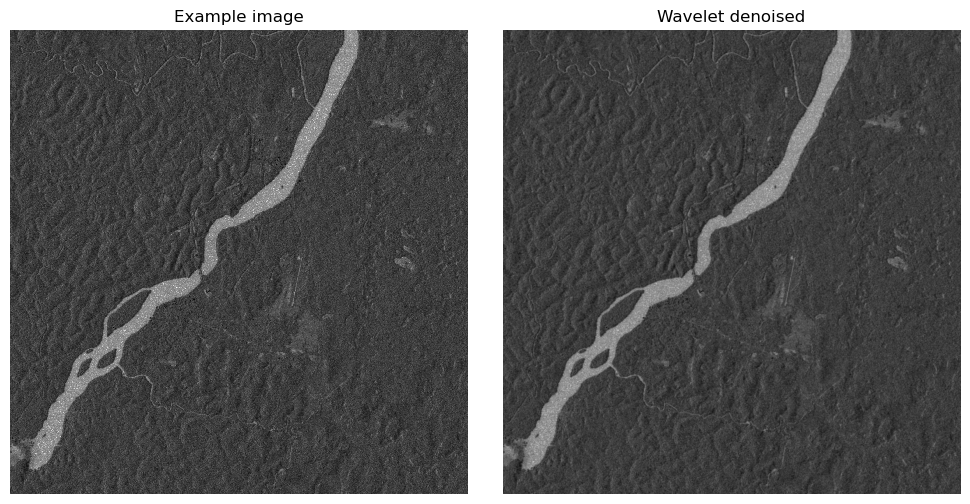

In [7]:
example = X[0]
denoised = denoise_swt(X[0])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(example, cmap='gray', interpolation='nearest')
axes[0].set_title('Example image')
axes[0].axis('off')  
axes[1].imshow(denoised, cmap='gray')
axes[1].set_title('Wavelet denoised')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Finally, the WECS methodology is applied to the data, returning a raster that represents the *change correlation* of each pixel.

In [8]:
start = time.time()
wecs = WECS(X)
end = time.time()
elapsed_time = end - start
print(f"WECS elapsed time: {elapsed_time:.2f} seconds.")

WECS elapsed time: 341.81 seconds.


This image can be classified using any conventional image segmentation method. The following plots show:
1. The correlation image resulting from the WECS method;
2. The segmented images using the Otsu, Kittler-Illingworth and KMeans algorithms (yellow shows change, blue shows non-change).

In [9]:
otsu_classified_wecs = segment2d(wecs, method='ot')
ki_classified_wecs = segment2d(wecs, method='ki')
kmeans_classified_wecs = segment2d(wecs, method='km')

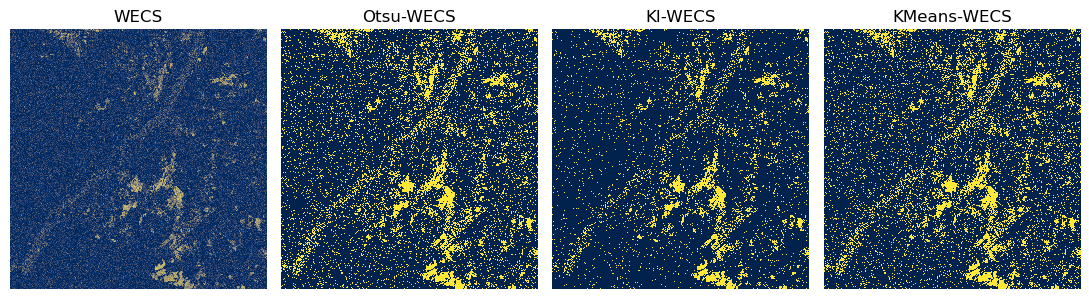

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(11, 8))

axes[0].imshow(wecs, cmap='cividis', interpolation='nearest')
axes[0].set_title('WECS')
axes[0].axis('off')  
axes[1].imshow(otsu_classified_wecs, cmap='cividis', interpolation='nearest')
axes[1].set_title('Otsu-WECS')
axes[1].axis('off')
axes[2].imshow(ki_classified_wecs, cmap='cividis', interpolation='nearest')
axes[2].set_title('KI-WECS')
axes[2].axis('off')
axes[3].imshow(kmeans_classified_wecs, cmap='cividis', interpolation='nearest')
axes[3].set_title('KMeans-WECS')
axes[3].axis('off')

plt.tight_layout()
plt.show()